In [85]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import spectral
import textwrap
import csv

In [86]:
def calculate_ndsi(band4, band6):
        return (band4 - band6) / (band4 + band6)

def create_sca_mask(data, threshold):
    return np.where(data > threshold, 1, 0)

def save_modis_binary_map(data, title, filename): #resolution 15km per pixel
        wrapped_title = textwrap.fill(title, width=40)
        plt.imshow(data, cmap='gray')
        plt.title(wrapped_title)
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close()

def show_modis_binary_map(data, title):
        wrapped_title = textwrap.fill(title, width=40)
        plt.imshow(data, cmap='gray')
        plt.title(wrapped_title)
        plt.axis('off')
        plt.show()

def print_snow_stats(data):
    snow_pixels = np.count_nonzero(data == 1)
    no_snow_pixels = np.count_nonzero(data == 0)
    total_pixels = data.size
    snow_percent = (snow_pixels / total_pixels) * 100
    no_snow_percent = (no_snow_pixels / total_pixels) * 100

    print(f"Snow Pixels: {snow_pixels}")
    print(f"No Snow Pixels: {no_snow_pixels}")
    print(f"Snow Percent: {snow_percent:.2f}%")
    print(f"No Snow Percent: {no_snow_percent:.2f}%")
    
    return snow_pixels, no_snow_pixels, snow_percent, no_snow_percent

C:\Users\laure\AppData\Local\Temp\ipykernel_14340\1916603521.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (band4 - band6) / (band4 + band6)


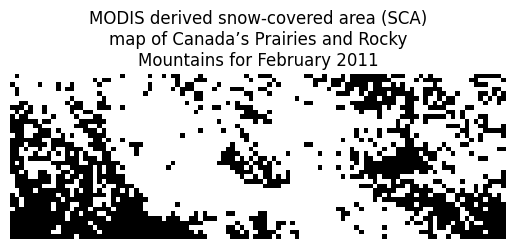

Snow Pixels: 2528
No Snow Pixels: 1360
Snow Percent: 65.02%
No Snow Percent: 34.98%


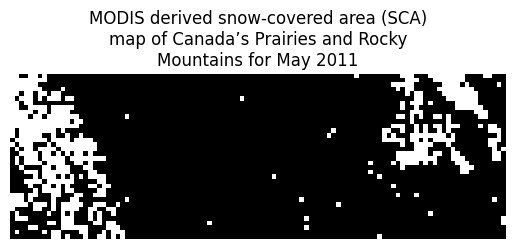

Snow Pixels: 609
No Snow Pixels: 3279
Snow Percent: 15.66%
No Snow Percent: 84.34%


In [87]:
def create_modis_sca_png(modis_path, threshold, title, output_path):
    # Load MODIS data
    modis_img = spectral.open_image(modis_path)

    # Extract MODIS data
    modis_data = modis_img.load() # Shape: (36, 108, 7) -> (rows, columns, bands)

    # Calculate the Normalized Difference Snow Index (NDSI)
    ndsi = calculate_ndsi(modis_data[:, :, 3], modis_data[:, :, 5])  # Bands are 0-indexed
    ndsi = np.squeeze(ndsi) # Remove singleton dimension (36, 108, 1) -> (36, 108)

    # Create a binary map of Snow-Covered Area (SCA)
    sca = create_sca_mask(ndsi, threshold)

    # Save SCA map as an image file
    save_modis_binary_map(sca, title, output_path)

    # Show SCA map
    show_modis_binary_map(sca, title)

    # Print snow statistics
    return print_snow_stats(sca)


title_feb = 'MODIS derived snow-covered area (SCA) map of Canada’s Prairies and Rocky Mountains for February 2011'
title_may = 'MODIS derived snow-covered area (SCA) map of Canada’s Prairies and Rocky Mountains for May 2011'
threshold = 0.4 # Threshold for non-forested region is NDSI > 0.4 = sca

modis_feb_stats = create_modis_sca_png('../322_Lab1_data/MODIS_20110201_15km.hdr', threshold, title_feb, 'output/sca_feb.png')
modis_may_stats = create_modis_sca_png('../322_Lab1_data/MODIS_20110501_15km.hdr', threshold, title_may, 'output/sca_may.png')


In [88]:
def convert_to_tbk(dn):
    return (dn * 0.01) + 327.68

def create_tb_mask(tb, threshold=255):
    return np.where(tb > threshold, np.nan, tb)

def calculate_swe(tb18_7, tb36_5, a=4.8):
    return a * (tb18_7 - tb36_5)

def save_amsre_binary_map(data, title, filename, transform, crs):
    wrapped_title = textwrap.fill(title, width=40)
    fig, ax = plt.subplots(figsize=(10, 10))
    show(data, transform=transform, ax=ax, cmap='gray')
    plt.title(wrapped_title)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

def show_amsre_binary_map(data, title, transform, crs):
    wrapped_title = textwrap.fill(title, width=40)
    fig, ax = plt.subplots(figsize=(10, 10))
    show(data, transform=transform, ax=ax, cmap='gray')
    plt.title(wrapped_title)
    plt.axis('off')
    plt.show()

(36, 108, 1)


C:\Users\laure\AppData\Local\Temp\ipykernel_14340\2613732825.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (dn * 0.01) + 327.68


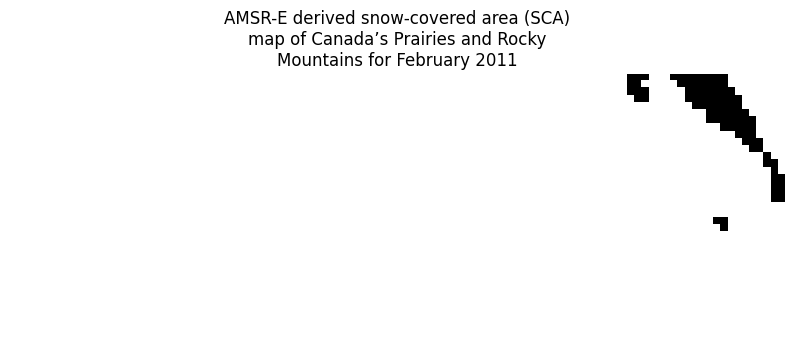

Snow Pixels: 3800
No Snow Pixels: 88
Snow Percent: 97.74%
No Snow Percent: 2.26%
(36, 108, 1)


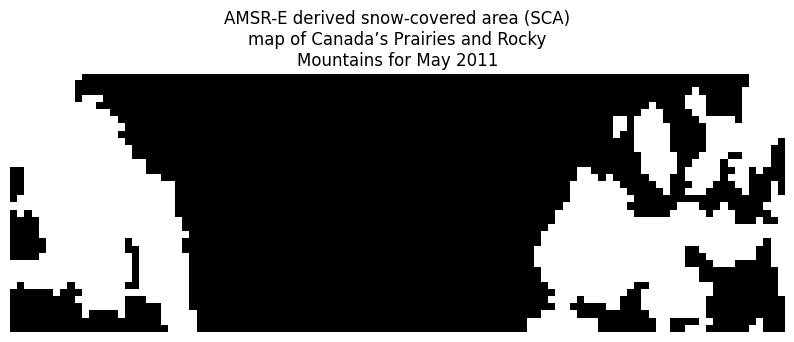

Snow Pixels: 1231
No Snow Pixels: 2657
Snow Percent: 31.66%
No Snow Percent: 68.34%


In [89]:
def create_amsre_sca_png(amsre_18_7_path, amsre_36_5_path, amsre_36_5_bin_path, threshold, title, output_path):
    # Load AMSR-E data
    amsre_18_7_img = spectral.open_image(amsre_18_7_path)
    amsre_36_5_img = spectral.open_image(amsre_36_5_path)

    # Extract AMSR-E data
    amsre_18_7_data = amsre_18_7_img.load()  # Shape: (rows, columns, bands)
    print(amsre_18_7_data.shape)
    amsre_36_5_data = amsre_36_5_img.load()

    # Convert DN to brightness temperature (Tb)
    tb18_7 = convert_to_tbk(amsre_18_7_data)
    tb36_5 = convert_to_tbk(amsre_36_5_data)

    # Create a mask for Tb > 255 K in the 36.5 GHz data to ensure dry snow conditions
    tb36_5_masked = create_tb_mask(tb36_5)

    # Calculate Snow Water Equivalent (SWE)
    swe = calculate_swe(tb18_7, tb36_5_masked)

    # Create a binary map of Snow-Covered Area (SCA)
    sca = create_sca_mask(swe, threshold)

    # Get geographic metadata from the ENVI header
    with rasterio.open(amsre_36_5_bin_path) as src:
        transform = src.transform  # Geographic transform
        crs = src.crs  # Coordinate reference system

    # Save SCA map as an image file
    save_amsre_binary_map(sca, title, output_path, transform, crs)

    # Show SCA map
    show_amsre_binary_map(sca, title, transform, crs)

    # Print statistics
    return print_snow_stats(sca)

# Titles
title_feb = 'AMSR-E derived snow-covered area (SCA) map of Canada’s Prairies and Rocky Mountains for February 2011'
title_may = 'AMSR-E derived snow-covered area (SCA) map of Canada’s Prairies and Rocky Mountains for May 2011'

# Paths to AMSR-E data
amsre_18_7_feb_path = '../322_Lab1_data/18-7GHz_20110201.hdr'
amsre_36_5_feb_path = '../322_Lab1_data/36-5GHz_20110201.hdr'
amsre_36_5_feb_bin_path = '../322_Lab1_data/36-5GHz_20110201'
amsre_18_7_may_path = '../322_Lab1_data/18-7GHz_20110501.hdr'
amsre_36_5_may_path = '../322_Lab1_data/36-5GHz_20110501.hdr'
amsre_36_5_may_bin_path = '../322_Lab1_data/36-5GHz_20110501'
threshold = 0 

# Create and save SCA maps for February and May
amsre_feb_stats = create_amsre_sca_png(amsre_18_7_feb_path, amsre_36_5_feb_path, amsre_36_5_feb_bin_path, threshold, title_feb, 'output/amsre_sca_feb.png')
amsre_may_stats = create_amsre_sca_png(amsre_18_7_may_path, amsre_36_5_may_path, amsre_36_5_may_bin_path, threshold, title_may, 'output/amsre_sca_may.png')


In [ ]:
# Function to save snow statistics to a CSV file
def save_snow_stats_to_csv(stats, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Dataset", "Snow Pixels", "No Snow Pixels", "Snow Percent", "No Snow Percent"])
        writer.writerows(stats)

stats = [
    ["MODIS February", *modis_feb_stats],
    ["MODIS May", *modis_may_stats],
    ["AMSR-E February", *amsre_feb_stats],
    ["AMSR-E May", *amsre_may_stats]
]

# Save snow statistics to a CSV file
save_snow_stats_to_csv(stats, 'output/snow_coverage_stats.csv')